Saving tcga_brca_clinical.tsv.gz to tcga_brca_clinical.tsv.gz
Saving tcga_brca_expression.tsv.gz to tcga_brca_expression.tsv.gz
Saving tcga_brca_mutations.tsv.gz to tcga_brca_mutations.tsv.gz

Files uploaded:
tcga_brca_clinical.tsv.gz
tcga_brca_expression.tsv.gz
tcga_brca_mutations.tsv.gz

Using files:
Expression: tcga_brca_expression.tsv.gz
Mutation: tcga_brca_mutations.tsv.gz
Clinical: tcga_brca_clinical.tsv.gz

Expression shape (genes x samples): (60660, 1226)
After transpose (samples x genes): (1226, 60660)

Mutation file loaded with shape: (89569, 12)
Columns: ['sample', 'gene', 'chrom', 'start', 'end', 'ref', 'alt', 'Tumor_Sample_Barcode', 'Amino_Acid_Change', 'effect']

Detected columns -> sample: Tumor_Sample_Barcode | gene: gene
BRCA1/2-mutated samples: 47

Label distribution:
 BRCA_status
0    1178
1      48
Name: count, dtype: int64
Merged data shape: (1226, 60661)
Genes remaining after variance filter: 57527

Model Evaluation:
Accuracy: 0.962
ROC-AUC: 0.438
Confusion matrix

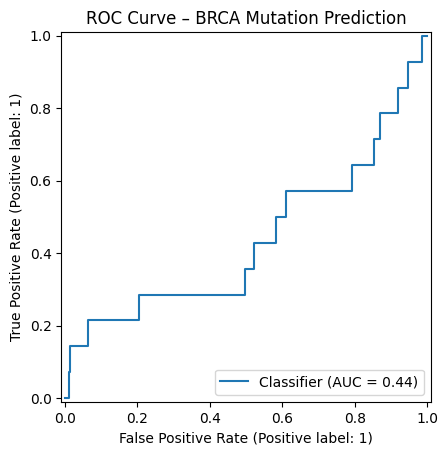


Top 20 predictive genes:
 Ensembl_ID
ENSG00000201016.1     0.033823
ENSG00000233546.1     0.030831
ENSG00000258713.3     0.029344
ENSG00000207969.1     0.025039
ENSG00000249045.1     0.024125
ENSG00000224486.1     0.022756
ENSG00000235661.3     0.021718
ENSG00000236405.1     0.021692
ENSG00000278110.1     0.021389
ENSG00000036828.17    0.020828
ENSG00000203878.11    0.020284
ENSG00000222154.1     0.019895
ENSG00000257746.2     0.019005
ENSG00000199085.3     0.018845
ENSG00000255037.1     0.018642
ENSG00000232058.1     0.018527
ENSG00000129862.7     0.018269
ENSG00000258902.1     0.018258
ENSG00000284407.1     0.018036
ENSG00000285638.1     0.017988
dtype: float64


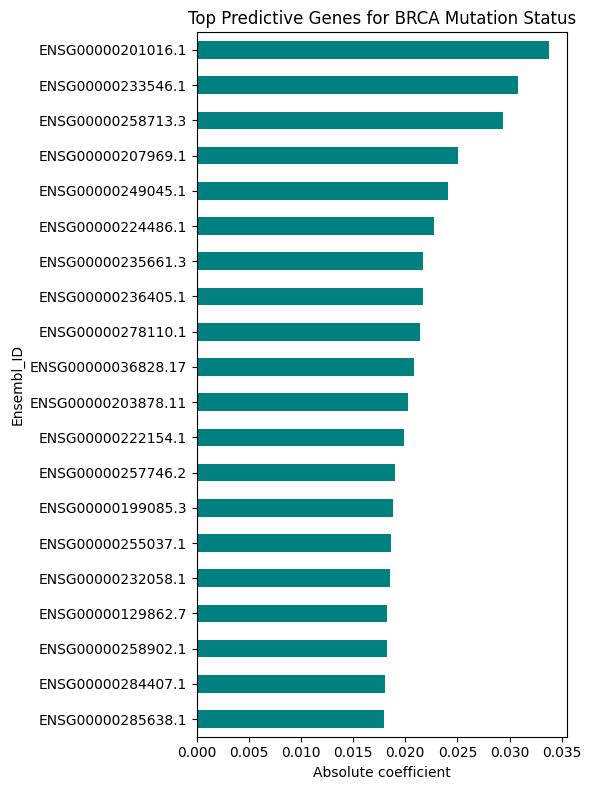

In [1]:
# ============================================================
# 0. Install required libraries
# ============================================================
!pip install pandas numpy scikit-learn matplotlib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import os

# ============================================================
# 1. Upload files to Colab
# ============================================================
from google.colab import files
uploaded = files.upload()

print("\nFiles uploaded:")
for fn in uploaded.keys():
    print(fn)

# ============================================================
# 2. Handle compressed (.gz) or normal (.tsv) files automatically
# ============================================================
def find_file(base_name):
    """Return either .tsv or .tsv.gz version if available"""
    if os.path.exists(base_name):
        return base_name
    if os.path.exists(base_name + ".gz"):
        return base_name + ".gz"
    raise FileNotFoundError(f"{base_name}(.gz) not found!")

expr_path = find_file("tcga_brca_expression.tsv")
mut_path  = find_file("tcga_brca_mutations.tsv")
clin_path = find_file("tcga_brca_clinical.tsv")

print("\nUsing files:")
print("Expression:", expr_path)
print("Mutation:", mut_path)
print("Clinical:", clin_path)

# ============================================================
# 3. Load gene expression matrix
# ============================================================
expr = pd.read_csv(expr_path, sep="\t", index_col=0, compression='infer')
print("\nExpression shape (genes x samples):", expr.shape)

# Transpose so each row = sample, each column = gene
expr_t = expr.T
expr_t.index.name = "sample_id"
print("After transpose (samples x genes):", expr_t.shape)

# ============================================================
# 4. Load mutation data
# ============================================================
mut = pd.read_csv(mut_path, sep="\t", compression='infer')
print("\nMutation file loaded with shape:", mut.shape)
print("Columns:", mut.columns.tolist()[:10])

# ============================================================
# 5. Detect sample and gene columns automatically
# ============================================================
sample_col = next((c for c in ["Tumor_Sample_Barcode", "sample", "case_id", "barcode"]
                   if c in mut.columns), None)
gene_col = next((c for c in ["Hugo_Symbol", "gene", "Gene", "symbol"]
                 if c in mut.columns), None)

print("\nDetected columns -> sample:", sample_col, "| gene:", gene_col)

# ============================================================
# 6. Extract BRCA1/BRCA2 mutations
# ============================================================
brca_mut = mut[mut[gene_col].isin(["BRCA1", "BRCA2"])].copy()
brca_mut["sample_short"] = brca_mut[sample_col].str[:12]
brca_mutated_samples = brca_mut["sample_short"].unique()
print("BRCA1/2-mutated samples:", len(brca_mutated_samples))

# ============================================================
# 7. Prepare expression + label table
# ============================================================
expr_t_short = expr_t.copy()
expr_t_short["sample_short"] = expr_t_short.index.str[:12]
expr_t_short = expr_t_short.set_index("sample_short")

labels = pd.Series(0, index=expr_t_short.index, name="BRCA_status")
labels.loc[labels.index.isin(brca_mutated_samples)] = 1
print("\nLabel distribution:\n", labels.value_counts())

data = expr_t_short.copy()
data["BRCA_status"] = labels
print("Merged data shape:", data.shape)

# ============================================================
# 8. Remove low-variance genes
# ============================================================
y = data["BRCA_status"]
X = data.drop(columns=["BRCA_status"])
variances = X.var(axis=0)
X = X.loc[:, variances > 1e-5]
print("Genes remaining after variance filter:", X.shape[1])

# ============================================================
# 9. Train/test split + scale
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# 10. Train model
# ============================================================
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# ============================================================
# 11. Evaluate model
# ============================================================
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm  = confusion_matrix(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC: {auc:.3f}")
print("Confusion matrix:\n", cm)

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve – BRCA Mutation Prediction")
plt.show()

# ============================================================
# 12. Identify top predictive genes
# ============================================================
coef = pd.Series(clf.coef_[0], index=X.columns)
top_genes = coef.abs().sort_values(ascending=False).head(20)
print("\nTop 20 predictive genes:\n", top_genes)

plt.figure(figsize=(6,8))
top_genes.sort_values().plot(kind="barh", color='teal')
plt.xlabel("Absolute coefficient")
plt.title("Top Predictive Genes for BRCA Mutation Status")
plt.tight_layout()
plt.show()


In [17]:
!pip install pandas numpy scikit-learn matplotlib imbalanced-learn xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer


In [18]:
# Keep only the most variable genes (e.g. top 1000)
N_TOP = 1000

variances = X.var(axis=0)
top_genes = variances.sort_values(ascending=False).head(N_TOP).index

X_reduced = X[top_genes].copy()
print("Original genes:", X.shape[1])
print("Reduced genes:", X_reduced.shape[1])


Original genes: 57527
Reduced genes: 1000


Top predictive genes (symbols):
 Ensembl_ID
RNU6-374P     0.033823
PRYP5         0.030831
C20orf141     0.029344
MIR507        0.025039
MTND3P24      0.024125
AL662795.1    0.022756
MIR670HG      0.021718
UBQLN1P1      0.021692
SUSD2P2       0.021389
CASR          0.020828
CHIAP2        0.020284
RN7SKP218     0.019895
AC138123.2    0.019005
MIR148A       0.018845
AC136443.2    0.018642
AC005772.1    0.018527
VCY1B         0.018269
AL049775.2    0.018258
MIR5001       0.018036
AL138927.1    0.017988
dtype: float64


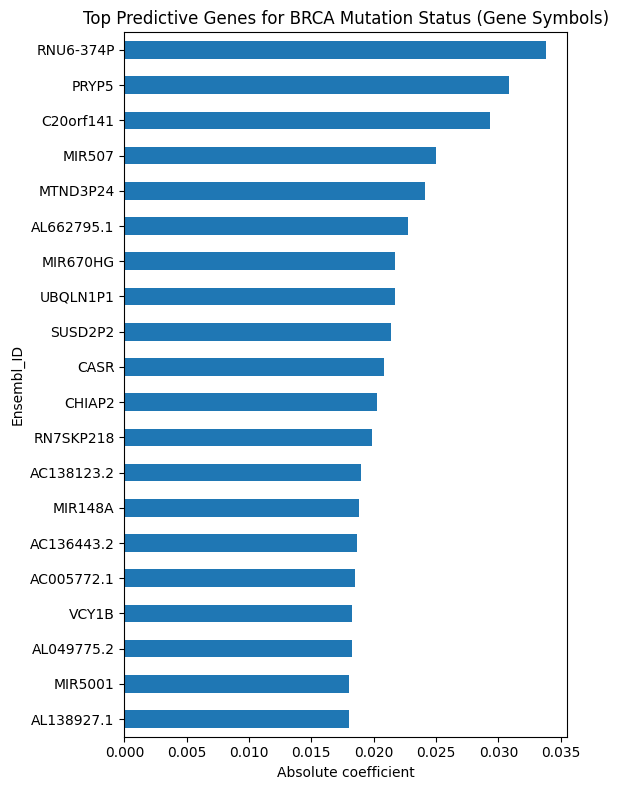

In [19]:
# Upload mapping file once:
# from google.colab import files
# uploaded = files.upload()

gene_map_path = "gencode.v36.annotation.gtf.gene.probemap"
gene_map = pd.read_csv(gene_map_path, sep="\t")

# Build mapping dict: Ensembl ID -> Gene Symbol
id_to_symbol = dict(zip(gene_map["id"], gene_map["gene"]))

# Assuming you have logistic regression coefficients from your baseline model:
# e.g. coef = pd.Series(log_clf.coef_[0], index=X_reduced.columns)

coef_named = coef.rename(index=id_to_symbol)
top_genes_named = coef_named.abs().sort_values(ascending=False).head(20)
print("Top predictive genes (symbols):\n", top_genes_named)

plt.figure(figsize=(6,8))
top_genes_named.sort_values().plot(kind="barh")
plt.xlabel("Absolute coefficient")
plt.title("Top Predictive Genes for BRCA Mutation Status (Gene Symbols)")
plt.tight_layout()
plt.show()


In [20]:
# Train/test split on X_reduced and y
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Handle imbalance with SMOTE (training only)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# Scale
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled      = scaler.transform(X_test)

# 1) Logistic Regression
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_res_scaled, y_train_res)
y_prob_log = log_clf.predict_proba(X_test_scaled)[:, 1]
print("LogReg - AUC:", roc_auc_score(y_test, y_prob_log))

# 2) Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf_clf.fit(X_train_res_scaled, y_train_res)
y_prob_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]
print("RandomForest - AUC:", roc_auc_score(y_test, y_prob_rf))

# 3) XGBoost
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)
xgb_clf.fit(X_train_res_scaled, y_train_res)
y_prob_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]
print("XGBoost - AUC:", roc_auc_score(y_test, y_prob_xgb))


Before SMOTE: {0: 824, 1: 34}
After SMOTE: {0: 824, 1: 824}
LogReg - AUC: 0.552865213882163
RandomForest - AUC: 0.6540556900726393
XGBoost - AUC: 0.6242937853107344


In [21]:
# Load clinical file if not already
# clin = pd.read_csv("tcga_brca_clinical.tsv.gz", sep="\t", compression="infer")

clin_sample_col = "sample"
clin_short = clin.copy()
clin_short["sample_short"] = clin_short[clin_sample_col].astype(str).str[:12]
clin_short = clin_short.set_index("sample_short")

# Drop duplicate patient rows
clin_unique = clin_short[~clin_short.index.duplicated(keep="first")]

# Choose meaningful clinical columns
clinical_cols = [
    "age_at_diagnosis.diagnoses",
    "ajcc_pathologic_stage.diagnoses",
    "tumor_grade.diagnoses",
    "progression_or_recurrence.diagnoses",
    "treatment_type.treatments.diagnoses"
]
clinical_cols = [c for c in clinical_cols if c in clin_unique.columns]
print("Using clinical columns:", clinical_cols)

# Make sure expression (X_reduced) and labels (y) have unique indices
X_unique = X_reduced.copy()
X_unique = X_unique[~X_unique.index.duplicated(keep="first")]

y_unique = y.copy()
y_unique = y_unique[~y_unique.index.duplicated(keep="first")]

# Intersection of samples across all three
common_samples = X_unique.index.intersection(clin_unique.index).intersection(y_unique.index)
print("Common samples:", len(common_samples))

X_common  = X_unique.loc[common_samples]
y_common  = y_unique.loc[common_samples]
clin_used = clin_unique.loc[common_samples, clinical_cols]

# One-hot encode clinical features
clin_used_encoded = pd.get_dummies(clin_used, drop_first=True)

print("Expression shape (common):", X_common.shape)
print("Clinical encoded shape:", clin_used_encoded.shape)

# Combine expression + clinical features
X_with_clin = pd.concat([X_common, clin_used_encoded], axis=1)
y_with_clin = y_common

print("Final shapes:")
print("X_with_clin:", X_with_clin.shape)
print("y_with_clin:", y_with_clin.shape)


Using clinical columns: ['age_at_diagnosis.diagnoses', 'ajcc_pathologic_stage.diagnoses', 'tumor_grade.diagnoses', 'progression_or_recurrence.diagnoses', 'treatment_type.treatments.diagnoses']
Common samples: 1095
Expression shape (common): (1095, 1000)
Clinical encoded shape: (1095, 13)
Final shapes:
X_with_clin: (1095, 1013)
y_with_clin: (1095,)


In [22]:
from sklearn.impute import SimpleImputer

print("Any NaNs before imputation:", X_with_clin.isna().any().any())

# Impute missing values with most frequent
imputer = SimpleImputer(strategy="most_frequent")
X_imputed_array = imputer.fit_transform(X_with_clin)
X_imputed = pd.DataFrame(X_imputed_array, index=X_with_clin.index, columns=X_with_clin.columns)

print("Any NaNs after imputation:", X_imputed.isna().any().any())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_with_clin,
    test_size=0.3,
    random_state=42,
    stratify=y_with_clin
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# Scale
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled      = scaler.transform(X_test)

# Random Forest with expression + clinical
rf_clin_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf_clin_clf.fit(X_train_res_scaled, y_train_res)

y_pred = rf_clin_clf.predict(X_test_scaled)
y_prob = rf_clin_clf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n=== Model with expression + clinical features ===")
print("Accuracy with clinical features:", acc)
print("ROC-AUC with clinical features:", auc)


Any NaNs before imputation: True
Any NaNs after imputation: False
Before SMOTE: {0: 733, 1: 33}
After SMOTE: {0: 733, 1: 733}

=== Model with expression + clinical features ===
Accuracy with clinical features: 0.9574468085106383
ROC-AUC with clinical features: 0.672562358276644


In [23]:
import os
import matplotlib.pyplot as plt

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

# Example: plotting top genes
plt.figure(figsize=(6,8))
top_genes_named.sort_values().plot(kind="barh", color="teal")
plt.xlabel("Absolute coefficient")
plt.title("Top Predictive Genes for BRCA Mutation Status (Gene Symbols)")
plt.tight_layout()

# Save figure
save_path = "results/top_genes.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"✅ Figure saved to {save_path}")


✅ Figure saved to results/top_genes.png
